# Chapter 5-2: Logistic Regression

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split

# https://pythonhosted.org/mord/
from mord import LogisticIT # Ordinal Logistic Regression

In [178]:
# if you get a "No module named 'mord'" error, uncomment and run the following:
#!pip install mord

## Example: Acceptance of Personal Loan

The Universal Bank dataset includes data on 5000 customers. The data include the customer’s response to the last personal loan campaign (`Personal Loan`), as well as customer demographic information (`Age`, `Income`, etc.) and the customer’s relationship with the bank (`mortgage`, `securities account`, etc.). Among these 5000 customers, only 480 (=9.6%) accepted the personal loan offered to them in a previous campaign. The goal is to build a model that identifies customers who are most likely to accept the loan offer in future mailings.

Load the `UniversalBank.csv` dataset. The columns `ID` and `ZIP Code` are not relevant for model building and therefore removed. Treat `Education` as categorical.

In [18]:
bank_df = pd.read_csv('data/UniversalBank.csv')
bank_df.drop(columns=['ID', 'ZIP Code'], inplace=True)
bank_df.columns = [c.replace(' ', '_') for c in bank_df.columns]

# treat education as categorical, convert to dummy variables
bank_df['Education'] = bank_df['Education'].astype('category')
new_categories = {1: 'Undergrad', 2: 'Graduate', 3: 'Advanced/Professional'}
bank_df.Education.cat.rename_categories(new_categories)
bank_df = pd.get_dummies(bank_df, prefix_sep='_', drop_first=True, dtype=int)
# logistic regression will only use two of the three categories 
# because using all three would create a multi-collinearity issue

y = bank_df['Personal_Loan']
X = bank_df.drop(columns=['Personal_Loan'])
X.head()

,Age,Experience,Income,Family,CCAvg,Mortgage,Securities_Account,CD_Account,Online,CreditCard,Education_2,Education_3
0,25,1,49,4,1.6,0,1,0,0,0,0,0
1,45,19,34,3,1.5,0,1,0,0,0,0,0
2,39,15,11,1,1.0,0,0,0,0,0,0,0
3,35,9,100,1,2.7,0,0,0,0,0,1,0
4,35,8,45,4,1.0,0,0,0,0,1,1,0


In [19]:
X.shape

(5000, 12)

In [20]:
# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('Accuracy on validation set is', logit_reg.score(valid_X, valid_y))

intercept  -12.148533253531447
           Age  Experience    Income    Family     CCAvg  Mortgage  \
coeff -0.04547    0.046808  0.058226  0.606423  0.237442  0.000995   

       Securities_Account  CD_Account    Online  CreditCard  Education_2  \
coeff           -0.988083    3.589957 -0.673348   -0.938242     4.131853   

       Education_3  
coeff     4.289538  

Accuracy on validation set is 0.9595


\begin{align*}
& {\rm Logit}({\rm Personal~Loan = Yes}) \\
& = −12.619 − 0.0325 {\rm~Age} + 0.0342 {\rm~Experience} \\
& ~~~~ +0.0588 {\rm~Income} + 0.6141 {\rm~Family} + 0.2405 {\rm~CCAvg} \\
& ~~~~+0.0010 {\rm~Mortgage} − 1.0262 {\rm~Securities\_Account} + 3.6479 {\rm~CD\_Account} −0.6779 {\rm~Online} − 0.9560 {\rm~CreditCard} \\
& ~~~~ +4.1922 {\rm~Education\_Graduate} + 4.3417 {\rm~Education\_Advanced/Professional}
\end{align*}

The positive coefficients for the dummy variables `Education_Graduate`, `Education_Advanced/Professional`, and `CD_Account` mean that holding a CD account and having graduate or professional education (all marked by 1 in the dummy variables) are associated with higher probabilities of accepting the loan offer. 

In contrast, having a securities account, using online banking, and owning a Universal Bank credit card are associated with lower acceptance rates. For the continuous predictors, positive coefficients indicate that a higher value on that predictor is associated with a higher probability of accepting the loan offer (e.g., `Income`: higher-income customers tend more to accept the offer). 

Similarly, negative coefficients indicate that a higher value on that predictor is associated with a lower probability of accepting the loan offer (e.g., `Age`: older customers are less likely to accept the offer).

In [16]:
# set to True to calculate logistic regression using Income only
if False:
    predictors = ['Income']
    outcome = 'Personal_Loan'

    y = bank_df[outcome]
    X = bank_df[predictors]

    # partition data
    train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

    # fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
    logit_reg_income = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
    logit_reg_income.fit(train_X, train_y)

    print('intercept ', logit_reg_income.intercept_[0])
    print(pd.DataFrame({'coefficient': logit_reg_income.coef_[0]}, index=X.columns).transpose())
    print()
    print('Accuracy on validation set is', logit_reg_income.score(valid_X, valid_y))

intercept  -6.048919279034499
               Income
coefficient  0.036343

Accuracy on validation set is 0.911


### Propensities for four customers in validation set

Predict to get the probabilities

In [21]:
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y, 
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

# display four different cases
interestingCases = [2764, 932, 2721, 702]
print(logit_result.loc[interestingCases])

      actual      p(0)      p(1)  predicted
2764       0  0.975453  0.024547          0
932        0  0.334829  0.665171          1
2721       1  0.033227  0.966773          1
702        1  0.985270  0.014730          0


### Training and validation confusion matrices

In [37]:
from sklearn.metrics import confusion_matrix

train_pred = logit_reg.predict(train_X)
valid_pred = logit_reg.predict(valid_X)

train_cm = confusion_matrix(train_y, train_pred)
valid_cm = confusion_matrix(valid_y, valid_pred)

train_cm = pd.DataFrame(train_cm, index=logit_reg.classes_, columns=logit_reg.classes_)
valid_cm = pd.DataFrame(valid_cm, index=logit_reg.classes_, columns=logit_reg.classes_)

print("Confusion matrix for training set:")
print(train_cm)
print('Accuracy on training set is', logit_reg.score(train_X, train_y).round(4) * 100, '%')
print() 


print("Confusion matrix for validation set:")
print(valid_cm)
print('Accuracy on validation set is', logit_reg.score(valid_X, valid_y).round(4) * 100, '%')


Confusion matrix for training set:
      0    1
0  2685   28
1    91  196
Accuracy on training set is 96.03 %

Confusion matrix for validation set:
      0    1
0  1791   16
1    65  128
Accuracy on validation set is 95.95 %


## Logistic Regression for Multiclass Classification

The logistic model for a binary outcome can be extended for more than two classes. Suppose that there are $m$ classes. Using a logistic regression model, for each record we would have $m$ probabilities of belonging to each of the $m$ classes. Since the $m$ probabilities must add up to 1, we need estimate only $m − 1$ probabilities.

### Ordinal classes 

Ordinal classes are classes that have a meaningful **order**. For example, in stock recommendations, the three classes `buy`, `hold`, and `sell` can be treated as ordered. As a simple rule, if classes can be numbered in a meaningful way, we consider them **ordinal**. 

* When the number of classes is large (typically, more than 5), we can treat the outcome variable as continuous and perform multiple linear regression. 

* When $m = 2$, the logistic model described above is used. We therefore need an extension of the logistic regression for a small number of ordinal classes ($3 ≤ m ≤ 5$). 

There are several ways to extend the binary-class case. Here, we describe the **proportional odds** or **cumulative logit method**.

For simplicity of interpretation and computation, we look at cumulative probabilities of class membership. For example, in the stock recommendations, we have $m=3$ classes. Let us denote them by $1={\rm buy}$, $2={\rm hold}$ and $3={\rm sell}$. The probabilities estimated by the model are $P(Y ≤ 1)$, (the probability of a buy recommendation) and $P(Y ≤ 2)$ (the probability of a buy or hold recommendation). The three noncumulative probabilities of class membership can easily be recovered from the two cumulative probabilities:
\begin{align*}
    P(Y=1) & = P(Y\leq 1) , \\
    P(Y=2) &= P(Y\leq 2) - P(Y\leq 1), \\
    P(Y=3) &= 1- P(Y\leq 2) .
\end{align*}

Next, we want to model each **logit** as a function of the predictors. Corresponding to each of the $m−1$ cumulative probabilities is a logit. In our example, we would have
\begin{align*}
    {\rm logit}({\rm buy}) &= \log \frac{P(Y\leq 1)}{1-P(Y\leq 1)} , \\
    {\rm logit}({\rm buy~or~hold}) &= \log \frac{P(Y\leq 2)}{1-P(Y\leq 2)} .
\end{align*}

Each of the logits is then modeled as a **linear function of the predictors** (as in the two-class case). If in the stock recommendations we have a single predictor value $x$, we compute two logit values using two equations
\begin{align*}
    {\rm logit}({\rm buy}) &=  \alpha_0 + \beta_1 x , \\
    {\rm logit}({\rm buy~or~hold}) &=  \beta_0 + \beta_1 x .
\end{align*}

This means that both lines have the **same slope** ($\beta_1$) but different **intercepts**. Once the coefficients $\alpha_0$, $|beta_0$, $\beta_1$ are estimated, we can compute the class membership probabilities by rewriting the logit equations in terms of probabilities. For the three-class case, we have
\begin{align*}
    P(Y=1) & = P(Y\leq 1) = \frac{1}{1+ e^{-(a_0+b_1 x)}} \\
    P(Y=2) &= P(Y\leq 2) - P(Y\leq 1) = \frac{1}{1+ e^{-(b_0+b_1 x)}} - \frac{1}{1+ e^{-(a_0+b_1 x)}}, \\
    P(Y=3) &= 1- P(Y\leq 2) = 1 -  \frac{1}{1+ e^{-(b_0+b_1 x)}},
\end{align*}
where $a_0$, $b_0$ and $b_1$ are the estimates obtained from the training set.

For each record, we now have the *estimated probabilities* that it belongs to each of the classes. In our example, each stock would have three probabilities: for a buy recommendation, a hold recommendation, and a sell recommendation. The last step is to classify the record into one of the classes. This is done by assigning it to the class with the **highest membership probability**. For example, if a stock had estimated probabilities $P (Y = 1) = 0.2$, $P (Y = 2) = 0.3$, and
$P (Y = 3) = 0.5$, we would classify it as getting a sell recommendation.

### Nominal Classes

When the classes **cannot be ordered** and are simply different from one another, we are in the case of **nominal classes**. An example is the choice between several brands of cereal. A simple way to verify that the classes are nominal is when it makes sense to tag them as A, B, C, . . ., and the assignment of letters to classes does not matter. Assume that there are $m = 3$ brands of cereal that consumers can choose from (assuming that each consumer chooses one). Then we estimate the probabilities $P (Y = A)$, $P (Y = B)$, and $P (Y = C )$. As before, if we know two of the probabilities, the third probability is determined. We therefore use one of the classes as the reference class. Let us use $C$ as the reference brand.


The goa is to model the class membership as a function of predictors. So in the cereals example, we might want to predict which cereal will be chosen if we know the cereal’s price $x$.

Next, we form $m−1$ pseudo-logit equations that are linear in the predictors:
\begin{align*}
    {\rm logit}(A) &= \log\frac{P(Y=A)}{P(Y=C)}  = \alpha_0 + \alpha_1 x , \\
    {\rm logit}(B) &=  \log\frac{P(Y=B)}{P(Y=C)}  = \beta_0 + \beta_1 x .
\end{align*}
Once the four coefficients are estimated from the training set, we can estimate the class membership probabilities:
\begin{align*}
    P(Y=A) &=  \frac{e^{a_0 + a_1 x }}{1+e^{a_0 + a_1 x }+e^{b_0 + b_1 x }}, \\
    P(Y=B) &=  \frac{e^{b_0 + b_1 x }}{1+e^{a_0 + a_1 x }+e^{b_0 + b_1 x }}, \\
    P(Y=C) & = \frac{1}{1+e^{a_0 + a_1 x }+e^{b_0 + b_1 x }},
\end{align*}
where $a_0$, $a_1$, $b_0$ and $b_1$ are the coefficient estimates obtained from the training set. Finally, a record is assigned to the class that has the **highest probability**.


### Comparing Ordinal and Nominal Models


The estimated logistic models will differ, depending on whether the outcome variable is coded as ordinal or nominal. Take, for example, data on accidents from the US Bureau of Transportation Statistics. These data can be used to predict whether an accident will result in injuries or fatalities based on predictors such as `alcohol involvement`, `time of day`, and `road condition`. The severity of the accident has three classes: 0 = `No Injury`, 1 = `Nonfatal Injuries`, 2 = `Fatalities`.


We first consider severity as an **ordinal** variable, and fit a simple model with two nominal predictors, `alcohol` and `weather`. Each of these predictors is coded as No (not involved in the accident) or Yes (involved in the accident). Next we change the modeling type for severity to **nominal**, and fit a model with the same predictors. The reference severity level, in both models, is severity = 2.

The resulting predicted probabilities differ across the two models. Hence, it is useful to determine which model is more suitable for the outcome at hand, and to evaluate predictive performance on a validation set.

In [87]:
data = pd.read_csv('data/accidentsFull.csv')
outcome = 'MAX_SEV_IR'
predictors = ['ALCHL_I', 'WEATHER_R']
print('predictors', predictors)
print()

y = data[outcome]
X = data[predictors]
classes = sorted(y.unique())

predictors ['ALCHL_I', 'WEATHER_R']



In [97]:
# Nominal logistic regression
logit = LogisticRegression(penalty="l2", solver='lbfgs', C=1e24, multi_class='multinomial')
logit.fit(X, y)

print('intercept', logit.intercept_)
print('coef', logit.coef_)
print('classes', logit.classes_)

probs = logit.predict_proba(X)
results = pd.DataFrame({
    'actual': y,
    'predicted': logit.predict(X),
    'P(a)': [p[0] for p in probs],
    'P(b)': [p[1] for p in probs],
    'P(c)': [p[2] for p in probs],
})
print(results.head())
print()

print('Training accruacy is', logit.score(X, y))

intercept [-0.09100315  0.9036454  -0.81264225]
coef [[ 0.51606685  0.3391015 ]
 [ 0.14900396  0.09543369]
 [-0.66507082 -0.43453518]]
classes [0 1 2]
   actual  predicted      P(a)      P(b)      P(c)
0       1          1  0.490649  0.498989  0.010362
1       0          0  0.553461  0.441147  0.005392
2       0          0  0.553461  0.441147  0.005392
3       0          1  0.490649  0.498989  0.010362
4       0          1  0.394192  0.578684  0.027124

Training accruacy is 0.5126946874333262


In [99]:
# Ordinal logistic regression
logit = LogisticIT(alpha=0)
logit.fit(X, y)

print('theta', logit.theta_)
print('coef', logit.coef_)
print('classes', logit.classes_)
print()

probs = logit.predict_proba(X)

results = pd.DataFrame({
    'actual': [yi for yi in y],
    'predicted': probs.argmax(axis=1),
    'P(a)': [p[0] for p in probs],
    'P(b)': [p[1] for p in probs],
    'P(c)': [p[2] for p in probs],
})
print(results.head())

print()
print('Training accruacy is', np.mean(results.predicted==y))

theta [-1.06916285  2.77444326]
coef [-0.40112008 -0.25174207]
classes [0 1 2]

   actual  predicted      P(a)      P(b)      P(c)
0       1          0  0.496205  0.482514  0.021281
1       0          0  0.558866  0.424510  0.016624
2       0          0  0.558866  0.424510  0.016624
3       0          0  0.496205  0.482514  0.021281
4       0          1  0.397402  0.571145  0.031453

Training accruacy is 0.5062465922290971


In [101]:
y.value_counts()

MAX_SEV_IR
1    20996
0    20721
2      466
Name: count, dtype: int64

In [103]:
def plotProbabilities(model):
    n = 100
    Xtest = pd.DataFrame({
        'ALCHL_I': [(i % n) * 0.1 + (j // n) * 0.1 - 5 for i in range(n) for j in range(n)],
        'WEATHER_R': [(i // n) * 0.1 + (j % n) * 0.1 - 5 for i in range(n) for j in range(n)],
    })
    probs = model.predict_proba(Xtest[predictors])

    results = pd.DataFrame({
        'predicted': model.predict(Xtest[predictors]),
        'P(a)': [round(10 * p[0]) / 10 for p in probs],
        'P(b)': [round(10 * p[1]) / 10 for p in probs],
        'P(c)': [round(10 * p[2]) / 10 for p in probs],
    })
    mapped = pd.concat([results, Xtest], axis=1, sort=False)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
    for i, c in enumerate(['P(a)', 'P(b)', 'P(c)']):
        ax = mapped.plot.scatter(x='ALCHL_I', y='WEATHER_R', c=c, title=c, colormap='cividis', ax=axes[i])
        if i > 0: 
            ax.set_ylabel('')

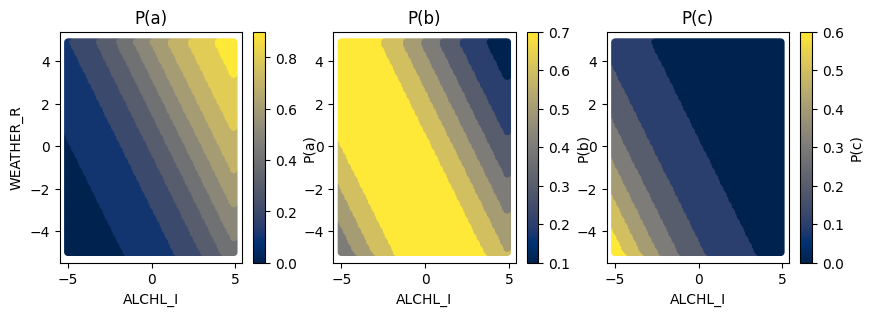

In [104]:
# Ordinal logistic regression
logit = LogisticIT(alpha=0)
logit.fit(X, y)
plotProbabilities(logit)

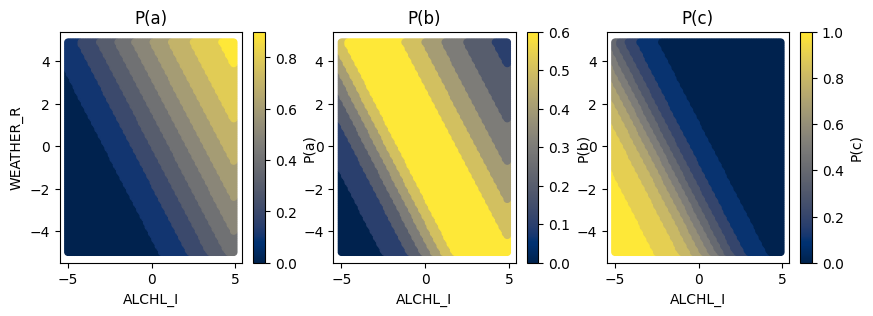

In [105]:
# Nominal logistic regression
logit = LogisticRegression(penalty="l2", solver='lbfgs', C=1e24, multi_class='multinomial')
logit.fit(X, y)
plotProbabilities(logit)

## Example: Predicting Delayed Flights

Predicting flight delays can be useful to a variety of organizations: airport authorities, airlines, aviation authorities. At times, joint task forces have been formed to address the problem. Such an organization, if it were to provide ongoing real-time assistance with flight delays, would benefit from some advance notice about flights likely to be delayed.

In this simplified illustration, we look at **six predictors**. The **outcome** of interest is whether the flight is **delayed or not**(delayed means more than 15 minutes late). Our data consist of all flights from the Washington, DC area into the New York City area during January 2004. The percent of delayed flights among these 2201 flights is 19.5%. The data were obtained from the Bureau of Transportation Statistics website (www.transtats.bts.gov).

In [109]:
delays_df = pd.read_csv('data/FlightDelays.csv')
delays_df.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime


In [113]:
# create an indicator variable
delays_df['isDelayed'] = [1 if status == 'delayed' else 0 for status in delays_df['Flight Status']]

# group information by day of week and determine the average delay
averageDelay = delays_df.groupby(['DAY_WEEK'])['isDelayed'].mean()
averageDelay

DAY_WEEK
1    0.272727
2    0.205212
3    0.178125
4    0.153226
5    0.191816
6    0.096000
7    0.268775
Name: isDelayed, dtype: float64

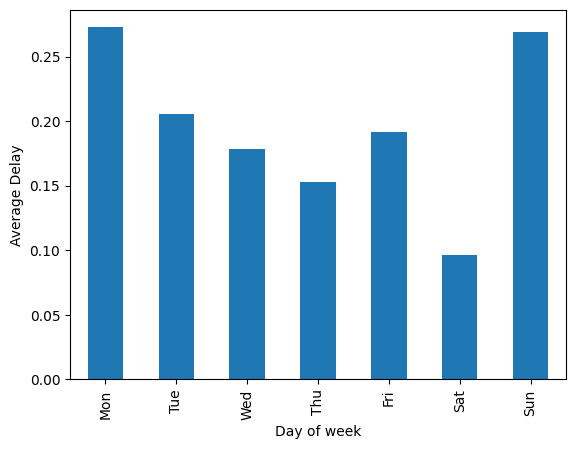

In [114]:
# create a bar chart
ax = averageDelay.plot.bar(color='C0')
ax.set_xlabel('Day of week')
ax.set_ylabel('Average Delay')
_ = ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

### Proportion of delayed flights by each of the six predictors. Time of day is divided into hourly bins


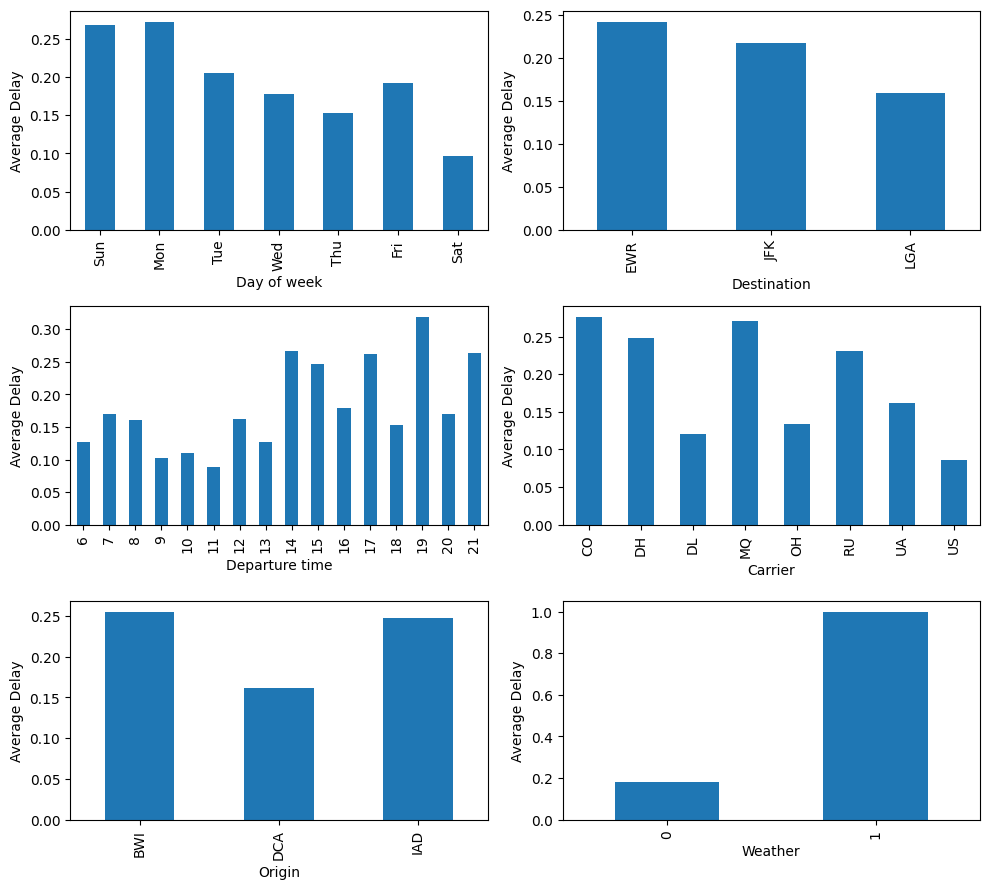

In [115]:
def createGraph(group, xlabel, axis):
    groupAverage = delays_df.groupby([group])['isDelayed'].mean()
    if group == 'DAY_WEEK': # rotate so that display starts on Sunday
        groupAverage = groupAverage.reindex(index=np.roll(groupAverage.index,1))
        groupAverage.index = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    ax = groupAverage.plot.bar(color='C0', ax=axis)
    ax.set_ylabel('Average Delay')
    ax.set_xlabel(xlabel)
    return ax

def graphDepartureTime(xlabel, axis):
    temp_df = pd.DataFrame({'CRS_DEP_TIME': delays_df['CRS_DEP_TIME'] // 100, 
                            'isDelayed': delays_df['isDelayed']})
    groupAverage = temp_df.groupby(['CRS_DEP_TIME'])['isDelayed'].mean()
    ax = groupAverage.plot.bar(color='C0', ax=axis)
    ax.set_xlabel(xlabel); ax.set_ylabel('Average Delay')
    
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 9))

createGraph('DAY_WEEK', 'Day of week', axis=axes[0][0])
createGraph('DEST', 'Destination', axis=axes[0][1])
graphDepartureTime('Departure time', axis=axes[1][0])
createGraph('CARRIER', 'Carrier', axis=axes[1][1])
createGraph('ORIGIN', 'Origin', axis=axes[2][0])
createGraph('Weather', 'Weather', axis=axes[2][1])
plt.tight_layout()

plt.show()

### Percent of delayed flights (darker = higher %delays) by day of week, origin and carrier

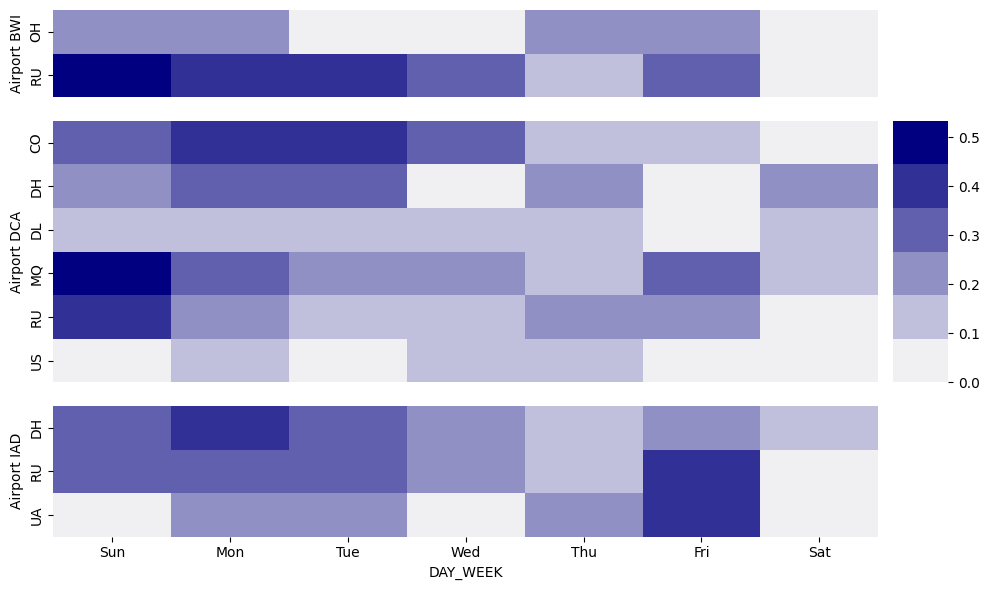

In [122]:
agg = delays_df.groupby(['ORIGIN', 'DAY_WEEK', 'CARRIER']).isDelayed.mean()
agg = agg.reset_index()

# Define the layout of the graph
height_ratios = []
for i, origin in enumerate(sorted(delays_df.ORIGIN.unique())):
    height_ratios.append(len(agg[agg.ORIGIN == origin].CARRIER.unique()))
gridspec_kw = {'height_ratios': height_ratios, 'width_ratios': [15, 1]}
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), 
                         gridspec_kw = gridspec_kw)
axes[0, 1].axis('off')
axes[2, 1].axis('off')

maxIsDelay = agg.isDelayed.max()
for i, origin in enumerate(sorted(delays_df.ORIGIN.unique())):
    data = pd.pivot_table(agg[agg.ORIGIN == origin], values='isDelayed', aggfunc='sum', 
                          index=['CARRIER'], columns=['DAY_WEEK'])
    data = data[[7, 1, 2, 3, 4, 5, 6]]  # Shift last columns to first
    ax = sns.heatmap(data, ax=axes[i][0], vmin=0, vmax=maxIsDelay, 
                     cbar_ax=axes[1][1], cmap=sns.light_palette("navy"))
    ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
    if i != 2: 
        ax.get_xaxis().set_visible(False)
    ax.set_ylabel('Airport ' + origin)

plt.tight_layout()
plt.show()

The above two figures show visualizations of the relationships between flight delays and different predictors or combinations of predictors. 

* From the first Fig, we see that Sundays and Mondays saw the largest proportion of delays. Delay rates also seem to differ by `carrier`, by `time of day`, as well as by `origin` and `destination airports`. For `Weather`, we see a strong distinction between delays when Weather = 1 (in that case there is always a delay) and Weather = 0. 

* The **heatmap** in the second Fig reveals some specific combinations with high rates of delays, such as Sunday flights by carrier RU, departing from BWI, or Sunday flights by MQ departing from DCA. We can also see combinations with very low delay rates.

Our main goal is to find a model that can obtain accurate classifications of new flights based on their predictor information. An alternative goal is finding a certain percentage of flights that are most/least likely to get delayed (**ranking**). And a third different goal is **profiling flights**: finding out which factors are associated with a delay (not only in this sample but in the entire population of flights on this route), and for those factors we would like to quantify these effects. A logistic regression model can be used for all these goals, albeit in different ways.

In [173]:
delays_df = pd.read_csv('data/FlightDelays.csv')
delays_df['isDelayed'] = [1 if status == 'delayed' else 0 
                          for status in delays_df['Flight Status']]

# convert to categorical
delays_df.DAY_WEEK = delays_df.DAY_WEEK.astype('category')

# create hourly bins departure time 
delays_df.CRS_DEP_TIME = [round(t / 100) for t in delays_df.CRS_DEP_TIME]
delays_df.CRS_DEP_TIME = delays_df.CRS_DEP_TIME.astype('category')

predictors = ['DAY_WEEK', 'CRS_DEP_TIME', 'ORIGIN', 'DEST', 'CARRIER', 'Weather']
outcome = 'isDelayed'

X = pd.get_dummies(delays_df[predictors], drop_first=True)
y = delays_df[outcome]
classes = ['ontime', 'delayed']

# split into training and validation
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, 
                                                      random_state=1)

logit_full = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_full.fit(train_X, train_y)

pd.set_option('display.width', 95)
pd.set_option('display.precision',3)
pd.set_option('display.max_columns', 33)
print('intercept ', logit_full.intercept_[0])

print(pd.DataFrame({'coeff': logit_full.coef_[0]}, index=X.columns).transpose())
print()
print('Accuracy on validation set is', logit_full.score(valid_X, valid_y))
pd.reset_option('display.width')
pd.reset_option('display.precision')
pd.reset_option('display.max_columns')

intercept  -1.2191109994100229
       Weather  DAY_WEEK_2  DAY_WEEK_3  DAY_WEEK_4  DAY_WEEK_5  DAY_WEEK_6  DAY_WEEK_7  \
coeff    9.325      -0.598      -0.705      -0.799      -0.296      -1.129      -0.135   

       CRS_DEP_TIME_7  CRS_DEP_TIME_8  CRS_DEP_TIME_9  CRS_DEP_TIME_10  CRS_DEP_TIME_11  \
coeff           0.631           0.382          -0.365            0.337            0.078   

       CRS_DEP_TIME_12  CRS_DEP_TIME_13  CRS_DEP_TIME_14  CRS_DEP_TIME_15  CRS_DEP_TIME_16  \
coeff            0.399            0.175            0.202            1.265            0.628   

       CRS_DEP_TIME_17  CRS_DEP_TIME_18  CRS_DEP_TIME_19  CRS_DEP_TIME_20  CRS_DEP_TIME_21  \
coeff            1.093            0.285            1.655            1.023            1.077   

       ORIGIN_DCA  ORIGIN_IAD  DEST_JFK  DEST_LGA  CARRIER_DH  CARRIER_DL  CARRIER_MQ  \
coeff       -0.01      -0.134    -0.524    -0.546       0.352      -0.685       0.743   

       CARRIER_OH  CARRIER_RU  CARRIER_UA  CARRI

In [174]:
from sklearn.metrics import confusion_matrix

logit_full_pred = logit_full.predict_proba(valid_X)
full_result = pd.DataFrame({'actual': valid_y, 
                            'p(0)': [p[0] for p in logit_reg_pred],
                            'p(1)': [p[1] for p in logit_reg_pred],
                            'predicted': logit_full.predict(valid_X)})
full_result = full_result.sort_values(by=['p(1)'], ascending=False)


cm = confusion_matrix(full_result['actual'], full_result['predicted'])
cm = pd.DataFrame(cm, index=logit_full.classes_, columns=logit_full.classes_)
print('Confusion matrix for validation set (full model):')
print(cm)
print()
print('Accuracy on validation set is', logit_full.score(valid_X, valid_y).round(4) * 100, '%')

Confusion matrix for validation set (full model):
     0   1
0  705   9
1  140  27

Accuracy on validation set is 83.09 %


In [175]:
delays_df = pd.read_csv('data/FlightDelays.csv')
delays_df['isDelayed'] = [1 if status == 'delayed' else 0 
                          for status in delays_df['Flight Status']]
delays_df['CRS_DEP_TIME'] = [round(t / 100) for t in delays_df['CRS_DEP_TIME']]
delays_red_df = pd.DataFrame({
    'Sun_Mon' : [1 if d in (1, 7) else 0 for d in delays_df.DAY_WEEK],
    'Weather' : delays_df.Weather,
    'CARRIER_CO_MQ_DH_RU' : [1 if d in ("CO", "MQ", "DH", "RU") else 0 
                             for d in delays_df.CARRIER],
    'MORNING' : [1 if d in (6, 7, 8, 9) else 0 for d in delays_df.CRS_DEP_TIME],
    'NOON' : [1 if d in (10, 11, 12, 13) else 0 for d in delays_df.CRS_DEP_TIME],
    'AFTER2P' : [1 if d in (14, 15, 16, 17, 18) else 0 for d in delays_df.CRS_DEP_TIME],
    'EVENING' : [1 if d in (19, 20) else 0 for d in delays_df.CRS_DEP_TIME],
    'isDelayed' : [1 if status == 'delayed' else 0 for status in delays_df['Flight Status']],
})

X = delays_red_df.drop(columns=['isDelayed'])
y = delays_red_df['isDelayed']
classes = ['ontime', 'delayed']

# split into training and validation
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, 
                                                      random_state=1)

logit_l1 = LogisticRegressionCV(penalty="l1", solver='liblinear', cv=5)
logit_l1.fit(train_X, train_y)

pd.set_option('display.width', 100)
print('regularization', logit_l1.C_)
print('intercept ', logit_l1.intercept_[0])
print(pd.DataFrame({'coeff': logit_l1.coef_[0]}, index=X.columns).transpose())
pd.reset_option('display.width')
print() 

cm = confusion_matrix(valid_y, logit_l1.predict(valid_X))
cm = pd.DataFrame(cm, index=logit_l1.classes_, columns=logit_l1.classes_)
print('Confusion matrix for validation set (reduced model):')
print(cm)
print()
print('Accuracy on validation set is', logit_l1.score(valid_X, valid_y).round(4) * 100, '%')

regularization [2.7825594]
intercept  -2.2872226457169353
        Sun_Mon   Weather  CARRIER_CO_MQ_DH_RU   MORNING      NOON   AFTER2P   EVENING
coeff  0.577923  4.977957             1.298782 -0.583334 -0.665944 -0.055244  0.560799

Confusion matrix for validation set (reduced model):
     0   1
0  711   3
1  143  24

Accuracy on validation set is 83.43 %


In [166]:
logit_l1_pred = logit_l1.predict_proba(valid_X)
l1_result = pd.DataFrame({'actual': valid_y, 
                            'p(0)': [p[0] for p in logit_l1_pred],
                            'p(1)': [p[1] for p in logit_l1_pred],
                            'predicted': logit_l1.predict(valid_X),
                          })
l1_result = l1_result.sort_values(by=['p(1)'], ascending=False)

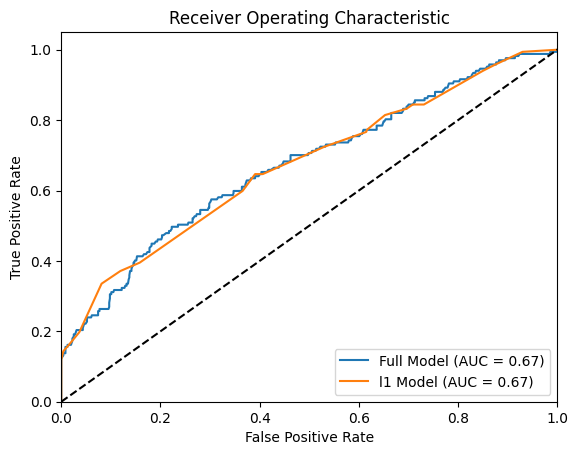

In [176]:
from sklearn.metrics import roc_curve, auc

# Calculate the false positive rate (FPR) and true positive rate (TPR) for the full model
fpr_full, tpr_full, _ = roc_curve(valid_y, logit_full_pred[:, 1])
roc_auc_full = auc(fpr_full, tpr_full)

# Calculate the false positive rate (FPR) and true positive rate (TPR) for the l1 model
fpr_l1, tpr_l1, _ = roc_curve(valid_y, logit_l1_pred[:, 1])
roc_auc_l1 = auc(fpr_l1, tpr_l1)

# Plot the ROC curves
plt.figure()
plt.plot(fpr_full, tpr_full, label='Full Model (AUC = %0.2f)' % roc_auc_full)
plt.plot(fpr_l1, tpr_l1, label='l1 Model (AUC = %0.2f)' % roc_auc_l1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Using `statsmodels`

`statsmodels` is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting **statistical tests**, and statistical data exploration. An extensive list of result statistics are available for each estimator. The results are tested against existing statistical packages to ensure that they are correct. The online documentation is hosted at [statsmodels.org](https://www.statsmodels.org/)
.



In [179]:
import statsmodels.api as sm

# same initial preprocessing and creating dummies

# add constant column (a column of 1s)
bank_df = sm.add_constant(bank_df, prepend=True)

y = bank_df['Personal_Loan']
X = bank_df.drop(columns=['Personal_Loan'])

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# use GLM (general linear model) with the binomial family to fit a logistic regression
logit_reg = sm.GLM(train_y, train_X, family=sm.families.Binomial())
logit_result = logit_reg.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          Personal_Loan   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2987
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -340.15
Date:                Sun, 04 Feb 2024   Deviance:                       680.30
Time:                        19:22:25   Pearson chi2:                 8.10e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.3325
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -12.5634      2